# TTC Subway Delay Data Analysis

# Summary

As someone who depends on the YU line for at least 5 days of the week, I am primarily concerned with delays happening on this particular line. In addition to obtaining a better overview of the state of delays for the whole subway system, I am interested in answering two questions:

1. If a delay was announced, should I stay home (if I check the alerts before leaving home) or get off the train for alternative means of transportation (if it occurred while I am already on the train)? I am okay with waiting for 10 minutes or so. 

According to the [analysis of delays with longest duration by line](#By-Subway-Line) and [proportion of lengthy delays by cause](#Longest-Delays), most types of delays are fairly short-lived, as long as it is not the rare bomb threat, suspicious package, police investigation, fire/smoke, doors opening in error or train hitting a person.

2. Which day of the week should I choose to work from home? Does that change depending on the season? 

According to the [visualization of delay counts and durations for the stations I use](#Delays-from-Finch-Union-on-YU-Line), for the next few months, Monday is the day to avoid to reduce the chances of being stuck in more delays, while Tuesday appears to be the best day, although the trend is not very clear and could have been affected by outlier events.

In addition to answering the above questions, I found the following:

- YU and BD lines are not impacted by weather (maybe because many stations on those lines are underground), but increasingly more by customer-related incidents (e.g. disruptive and ill patrons). On the other hand, weather effects are stronger for the SRT ine, which is the above-ground light rail line
- The vast majority of delay events are very short-lived (in the range of a few minutes) unless they are caused by injury at track level, fire or equipment/infrastructure-related outages
- The frequently occuring types of delays (e.g. passenger assistance alarm activation on train) tend to be quick to resolve, while serious issues are rare
- Overall, there have been a drop in operator overspeeding and miscellaneous speed control events reported (although that does not necessarily mean trains are arriving at their destinations faster)
- Terminal and intersecting stations tend to have more delays as measured by frequency and duration (although a delay at one station likely has domino effects affecting other trains on the same line, or at least the ones going in the same direction, since the train tracks do not have multiple lanes)
- Rush hours and weekdays experience more delays, but I did not find any noticeable month/seasonal trends, possibly because the two most popular lines (i.e. YU and BD lines) are not really affected by weather and the ridership population is stable throughout the year (e.g. no massive exodus for summer vacation; people need to take the trains for work and school regardless of season)
- Out of the last 5 years, 2018 was the worst year in terms of delays - there was a sharp rise in passenger-related delays, the addition of new stations likely caused additional operational issues, and the ATC project was also in full force during the year (which has continued into 2019 and 2020)

**Assumptions and Reliances:**

- No change in how the delay data is recorded over time, including definition of a delay event and delay causes
- Data provided is accurate and not missing any delay events (the large number of delays with 0 minutes is a bit suspicious, although we have no way of verifying them)

In [1]:
import re
import json
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
df = pd.read_csv('processed_data/ttc_subway_delay_data.csv', parse_dates = ['date'])

df['date'] = pd.Categorical(
    df.date, 
    categories = pd.date_range(start = '2014-01-01', end = '2019-12-31'), 
    ordered = True
)

df['weekday'] = pd.Categorical(
    df.weekday, 
    categories = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
    ordered = True
)

df.shape

(433252, 14)

In [3]:
df.dtypes

date                 category
time                   object
year                    int64
month                   int64
day                     int64
weekday              category
hour                    int64
line_cleaned           object
station_cleaned        object
code                   object
desc                   object
min_delay             float64
indicator_ns            int64
indicator_station       int64
dtype: object

In [4]:
df.head()

date   time  year  month  day   weekday  hour line_cleaned  \
0 2014-01-02  11:30  2014      1    1  Thursday    11           YU   
1 2014-01-02  11:30  2014      1    1  Thursday    11           YU   
2 2014-01-02  11:30  2014      1    1  Thursday    11           YU   
3 2014-01-02  11:30  2014      1    1  Thursday    11           YU   
4 2014-01-02  11:30  2014      1    1  Thursday    11           YU   

           station_cleaned  code                          desc  min_delay  \
0       VAUGHAN MC STATION  MUGD  Miscellaneous General Delays   0.013158   
1      HIGHWAY 407 STATION  MUGD  Miscellaneous General Delays   0.013158   
2  PIONEER VILLAGE STATION  MUGD  Miscellaneous General Delays   0.013158   
3  YORK UNIVERSITY STATION  MUGD  Miscellaneous General Delays   0.013158   
4       FINCH WEST STATION  MUGD  Miscellaneous General Delays   0.013158   

   indicator_ns  indicator_station  
0             1                  1  
1             0                  1  
2             0                  1  
3             0                  1  
4             0                  1

# Weather Effects

First, I wanted to investigate whether days with heavy rain or snow also tend to have more delays.

In [5]:
weather_data = pd.read_csv('weather_data/daily_weather.csv', parse_dates = ['date'])

weather_data['date'] = pd.Categorical(
    weather_data.date, 
    categories = pd.date_range(start = '2014-01-01', end = '2019-12-31'), 
    ordered = True
)

weather_data.head()

Longitude (x)  Latitude (y)    Station Name  Climate ID       date  Year  \
0         -79.63         43.68  TORONTO INTL A     6158731 2014-01-01  2014   
1         -79.63         43.68  TORONTO INTL A     6158731 2014-01-02  2014   
2         -79.63         43.68  TORONTO INTL A     6158731 2014-01-03  2014   
3         -79.63         43.68  TORONTO INTL A     6158731 2014-01-04  2014   
4         -79.63         43.68  TORONTO INTL A     6158731 2014-01-05  2014   

   Month  Day  Data Quality  Max Temp (°C)  ... snow_cm  Total Snow Flag  \
0      1    1           NaN          -10.0  ...     0.0              NaN   
1      1    2           NaN          -15.2  ...     1.0              NaN   
2      1    3           NaN           -9.2  ...     0.0              NaN   
3      1    4           NaN           -0.4  ...     0.4              NaN   
4      1    5           NaN           -0.1  ...    11.6              NaN   

  Total Precip (mm)  Total Precip Flag Snow on Grnd (cm)  Snow on Grnd Flag  \
0               0.0                NaN               3.0                NaN   
1               0.8                NaN               3.0                NaN   
2               0.0                NaN               4.0                NaN   
3               0.4                NaN               4.0                NaN   
4              14.4                NaN               6.0                NaN   

  Dir of Max Gust (10s deg)  Dir of Max Gust Flag Spd of Max Gust (km/h)  \
0                      27.0                   NaN                     35   
1                      35.0                   NaN                     48   
2                      21.0                   NaN                     41   
3                      23.0                   NaN                     57   
4                       NaN                   NaN                    <31   

   Spd of Max Gust Flag  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  

[5 rows x 31 columns]

I computed the number and duration of delays per day and compared it to the amount of rain and snow reported on those days for Toronto.

In [6]:
def get_n_dur(data):
    return pd.Series({'n_delays': data.indicator_ns.sum(),
                      'min_delays': data.min_delay.sum()})
    
summ_weather = (df.groupby(['date', 'month'])
                  .apply(get_n_dur)
                  .reset_index(drop = False)
                  .merge(
                      weather_data[['date', 'rain_mm', 'snow_cm']],
                      on = 'date',
                      how = 'left'
                   ))

summ_weather.head()

date  month  n_delays  min_delays  rain_mm  snow_cm
0 2014-01-01      1      44.0       211.0      0.0      0.0
1 2014-01-01      2       NaN         NaN      0.0      0.0
2 2014-01-01      3       NaN         NaN      0.0      0.0
3 2014-01-01      4       NaN         NaN      0.0      0.0
4 2014-01-01      5       NaN         NaN      0.0      0.0

Since Toronto tends to experience snow in the winter months, I compared snow levels with delay statistics in winter months (Nov - Feb), and rain levels with delays outside winter months (Mar - Oct).

The scatterplots below suggest that rain and snow are generally not correlated with subway delays, except for a few outliers with extreme weather conditions, so delays are mostly caused by non-weather related reasons. This is not too unsurprising since most of the subway lines are below ground, unaffected by above-ground road conditions.

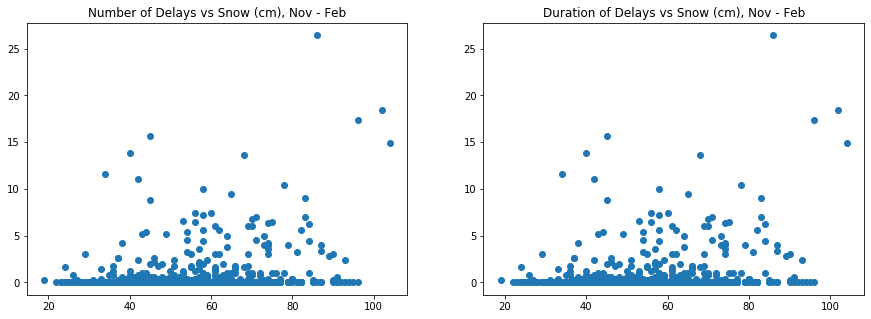

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (15, 5))

ax1.scatter(
    summ_weather[summ_weather.month.isin([11, 12, 1, 2])].n_delays, 
    summ_weather[summ_weather.month.isin([11, 12, 1, 2])].snow_cm
)
ax1.set_title('Number of Delays vs Snow (cm), Nov - Feb')

ax2.scatter(
    summ_weather[summ_weather.month.isin([11, 12, 1, 2])].n_delays, 
    summ_weather[summ_weather.month.isin([11, 12, 1, 2])].snow_cm
)
ax2.set_title('Duration of Delays vs Snow (cm), Nov - Feb')

plt.show()

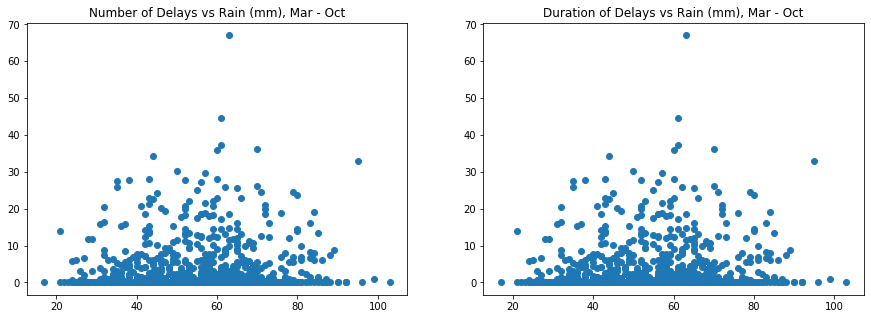

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (15, 5))

ax1.scatter(
    summ_weather[~summ_weather.month.isin([11, 12, 1, 2])].n_delays, 
    summ_weather[~summ_weather.month.isin([11, 12, 1, 2])].rain_mm
)
ax1.set_title('Number of Delays vs Rain (mm), Mar - Oct')

ax2.scatter(
    summ_weather[~summ_weather.month.isin([11, 12, 1, 2])].n_delays, 
    summ_weather[~summ_weather.month.isin([11, 12, 1, 2])].rain_mm
)
ax2.set_title('Duration of Delays vs Rain (mm), Mar - Oct')

plt.show()

# Overall Look

The vast majority of delay events are very short-lived (< 1min), which is reassuring news. However, the heavy concentration of delay events near 0-1 minutes makes it challenging to study the distribution of delay durations.

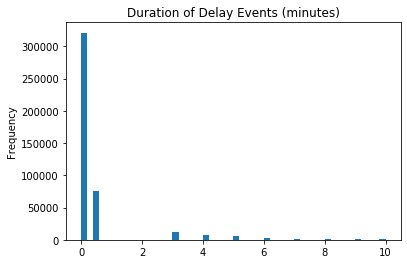

In [9]:
df.min_delay.plot(
    kind = 'hist', 
    bins = 50, 
    range = (0, df.min_delay.quantile(0.99)), 
    title = 'Duration of Delay Events (minutes)'
)

The plot below shows the total number of minutes spent in delays by station in each year (color coded by line). Already, we see big differences between stations. For example, Sheppard West and Wilson stations experienced an increase in delays over time, while Yonge BD, McCowan, Don Mills and Kenney stations saw improvements. Most stations remained fairly stable over the years. 

In [10]:
# line-station mapping
line_station_lookup = json.load(open('helper_data/stations_ordered.json')) 

# station-line mapping
station_line_lookup = {v: k for k in line_station_lookup for v in line_station_lookup[k]}

In [11]:
delay_dur_station_year = (df.groupby(['year', 'station_cleaned'])
                            .apply(lambda x: x.min_delay.sum())
                            .unstack('year'))

delay_dur_station_year.index = pd.Categorical(
    delay_dur_station_year.index,
    categories = line_station_lookup['YU'] + line_station_lookup['BD'] + \
                 line_station_lookup['SRT'] + line_station_lookup['SHP'],
    ordered = True
)

delay_dur_station_year.sort_index(inplace = True, ascending = False)

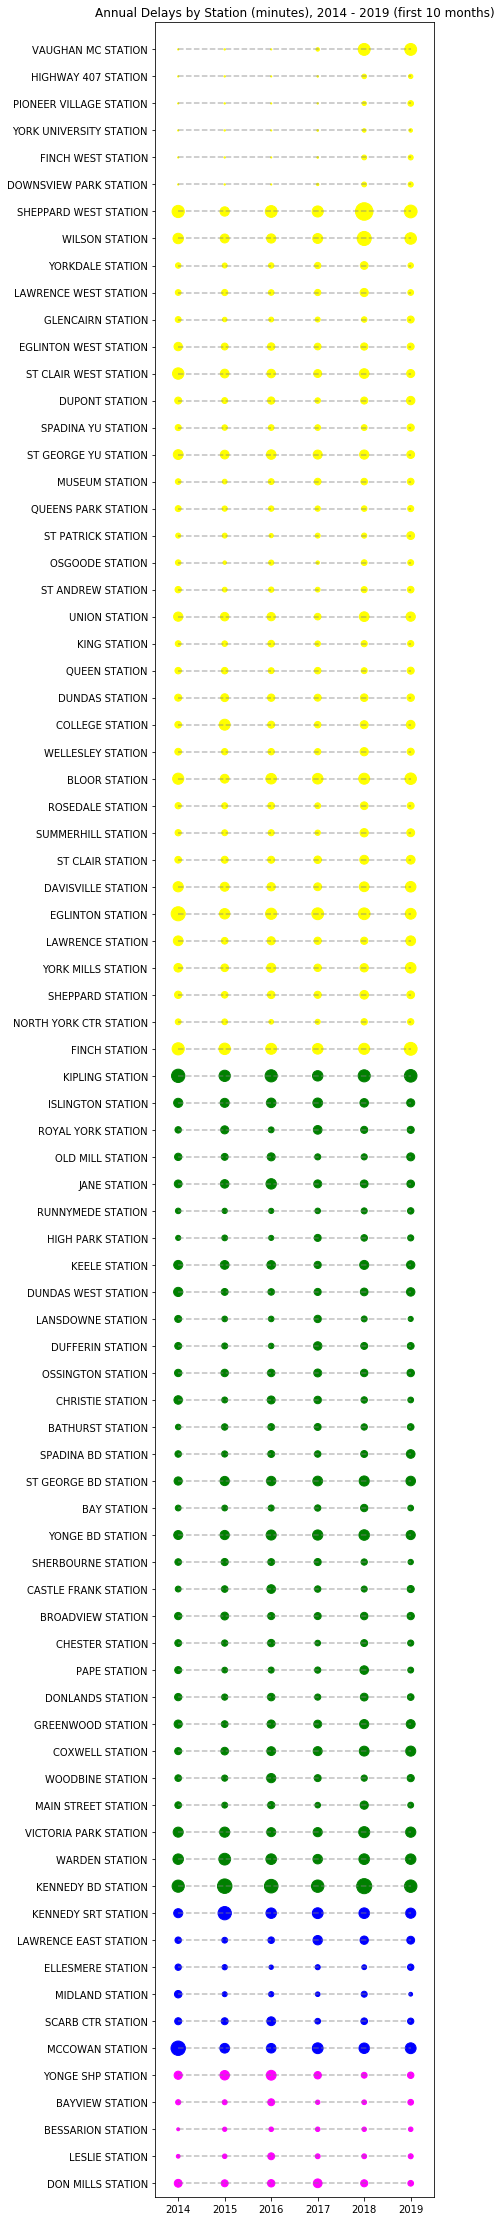

In [12]:
cmap = {'YU': 'yellow', 'BD': 'green', 'SRT': 'blue', 'SHP': 'magenta'}

ncols = delay_dur_station_year.shape[1]
nrows = delay_dur_station_year.shape[0]

x_per_row = np.arange(0, delay_dur_station_year.shape[1])
y_per_col = np.arange(0, delay_dur_station_year.shape[0])

x = np.tile(x_per_row, nrows)
y = np.repeat(y_per_col, ncols)
z = delay_dur_station_year.values
c = np.repeat([cmap[station_line_lookup[station_i]] for station_i in delay_dur_station_year.index], ncols)

plt.figure(figsize = (5, 40))

plt.scatter(x, y, s = z / 10, alpha = 1, c = c)

for index, row in delay_dur_station_year.iterrows():
    plt.plot(x_per_row, np.repeat(index, ncols), ls = '--', c = 'gray', alpha = 0.5)

plt.xlim((-0.5, ncols - 0.5))
plt.ylim((-0.5, nrows))

plt.xticks(x_per_row, labels = np.arange(2014, 2020))
plt.yticks(y_per_col, labels = delay_dur_station_year.index)
plt.title('Annual Delays by Station (minutes), 2014 - 2019 (first 10 months)')

plt.show()

# Longest Delays

What are the longest delays - when did they occur, where and what was the cause? 

In [13]:
longest_delays = df[df.min_delay > 60]

The serious delays tend to be caused by when a train hits a person, fire/smoke, weather delays and infrastructure-related outages (e.g. rail, track switch, signals). The biggest contributor by far across years is train in contact with person. The number of delays caused by weather also spiked in 2018.

In [14]:
pd.crosstab(longest_delays.desc, longest_delays.year).sort_values(by = 2019, ascending = False)

year                                               2014  2015  2016  2017  \
desc                                                                        
Priority One - Train in Contact With Person          13    11    11    22   
Weather Reports / Related Delays                      2     0     0     0   
Fire/Smoke Plan B - Source TTC                        1     3     5     3   
Fire/Smoke Plan A                                     1     0     1     0   
Rail Related Problem                                  3     0     0     0   
Rail Defect/Fastenings/Power Rail                     0     1     2     2   
Unauthorized at Track Level                           1     1     2     1   
Fire/Smoke Plan B                                     1     1     0     0   
Bomb Threat                                           1     1     0     0   
Track Switch Failure - Signal Related Problem         0     0     0     1   
Held By Polce - Non-TTC Related                       0     0     0     0   
Signals or Related Components Failure                 2     0     1     2   
S/E/C Department Other                                0     0     2     0   
Signals Track Weather Related                         0     0     0     0   
Structure Related Problem                             1     0     0     0   
Suspicious Package                                    0     0     0     0   
Traction Power Rail Related                           1     0     0     0   
Rail Cars & Shops Opr. Error                          0     0     0     0   
Train Control - VOBC                                  0     0     0     1   
Traction Power or Related Components Failure          1     1     1     0   
Trainline System                                      0     0     0     0   
VCC/RCIU/CCR                                          0     2     0     0   
Subway Radio System Fault                             0     2     1     0   
ATC Project                                           0     0     0     0   
Station Other                                         2     0     0     0   
Signals - Track Circuit Problems                      0     1     0     0   
Assault / Patron Involved                             0     0     0     1   
Passenger Other                                       0     0     0     0   
Other                                                 1     0     1     0   
Miscellaneous Other                                   0     1     0     2   
Misc. Engineering & Construction Related Problems     0     0     0     1   
Loop Related Failures                                 0     0     0     0   
High Voltage                                          0     1     1     0   
Force Majeure                                         1     5     0     0   
Work Zone Problems - Track                            1     0     0     0   

year                                               2018  2019  
desc                                                           
Priority One - Train in Contact With Person          20    16  
Weather Reports / Related Delays                      7     4  
Fire/Smoke Plan B - Source TTC                        4     4  
Fire/Smoke Plan A                                     0     3  
Rail Related Problem                                  1     2  
Rail Defect/Fastenings/Power Rail                     0     2  
Unauthorized at Track Level                           0     2  
Fire/Smoke Plan B                                     1     2  
Bomb Threat                                           2     2  
Track Switch Failure - Signal Related Problem         1     2  
Held By Polce - Non-TTC Related                       1     1  
Signals or Related Components Failure                 0     1  
S/E/C Department Other                                0     1  
Signals Track Weather Related                         0     1  
Structure Related Problem                             0     1  
Suspicious Package                                    3     1 

Comparing the lines, there was a jump in the number of serious delays in 2017 for BD line, and in 2018 for YU line. 

On the BD line, a big driver seems to be train in contact with person. On the YU line, fire and ATC project appear responsible for the increased number of lengthy delays, although they are not the sole causes. 

In [15]:
pd.crosstab(longest_delays.line_cleaned, longest_delays.year)

year          2014  2015  2016  2017  2018  2019
line_cleaned                                    
BD              18    12    13    20    22    19
SHP              1     3     3     3     1     1
SRT              4     6     4     5    11     8
YU              10    10     8     8    20    20

In [16]:
pd.crosstab(longest_delays[longest_delays.line_cleaned == 'BD'].desc, 
            longest_delays[longest_delays.line_cleaned == 'BD'].year).sort_values(by = 2017, ascending = False)

year                                               2014  2015  2016  2017  \
desc                                                                        
Priority One - Train in Contact With Person          12     8     5    15   
Fire/Smoke Plan B - Source TTC                        1     1     4     2   
Assault / Patron Involved                             0     0     0     1   
Unauthorized at Track Level                           0     0     2     1   
Misc. Engineering & Construction Related Problems     0     0     0     1   
Subway Radio System Fault                             0     1     0     0   
Weather Reports / Related Delays                      0     0     0     0   
Traction Power or Related Components Failure          1     0     0     0   
Traction Power Rail Related                           0     0     0     0   
Track Switch Failure - Signal Related Problem         0     0     0     0   
Suspicious Package                                    0     0     0     0   
Signals or Related Components Failure                 1     0     1     0   
Structure Related Problem                             1     0     0     0   
Bomb Threat                                           0     0     0     0   
S/E/C Department Other                                0     0     0     0   
Passenger Other                                       0     0     0     0   
Held By Polce - Non-TTC Related                       0     0     0     0   
Force Majeure                                         1     2     0     0   
Fire/Smoke Plan A                                     0     0     1     0   
Work Zone Problems - Track                            1     0     0     0   

year                                               2018  2019  
desc                                                           
Priority One - Train in Contact With Person          12     8  
Fire/Smoke Plan B - Source TTC                        1     3  
Assault / Patron Involved                             1     0  
Unauthorized at Track Level                           0     1  
Misc. Engineering & Construction Related Problems     0     0  
Subway Radio System Fault                             0     0  
Weather Reports / Related Delays                      0     1  
Traction Power or Related Components Failure          0     0  
Traction Power Rail Related                           0     1  
Track Switch Failure - Signal Related Problem         1     1  
Suspicious Package                                    1     1  
Signals or Related Components Failure                 0     0  
Structure Related Problem                             0     0  
Bomb Threat                                           1     1  
S/E/C Department Other                                0     1  
Passenger Other                                       1     0  
Held By Polce - Non-TTC Related                       0     1  
Force Majeure                                         2     0  
Fire/Smoke Plan A                                     0     0  
Work Zone Problems - Track                            1     0

In [17]:
pd.crosstab(longest_delays[longest_delays.line_cleaned == 'YU'].desc, 
            longest_delays[longest_delays.line_cleaned == 'YU'].year).sort_values(by = 2018, ascending = False)

year                                           2014  2015  2016  2017  2018  \
desc                                                                          
Priority One - Train in Contact With Person       1     3     5     7     8   
Fire/Smoke Plan B - Source TTC                    0     1     1     0     3   
ATC Project                                       0     0     0     0     2   
Suspicious Package                                0     0     0     0     1   
Assault / Patron Involved                         0     0     0     0     1   
Rail Related Problem                              3     0     0     0     1   
Weather Reports / Related Delays                  1     0     0     0     1   
Held By Polce - Non-TTC Related                   0     0     0     0     1   
Force Majeure                                     0     3     0     0     1   
Bomb Threat                                       1     1     0     0     1   
Miscellaneous Other                               0     1     0     0     0   
Rail Cars & Shops Opr. Error                      0     0     0     0     0   
Fire/Smoke Plan A                                 1     0     0     0     0   
Signals Track Weather Related                     0     0     0     0     0   
Signals or Related Components Failure             1     0     0     1     0   
Station Other                                     2     0     0     0     0   
Structure Related Problem                         0     0     0     0     0   
Subway Radio System Fault                         0     0     1     0     0   
Track Switch Failure - Signal Related Problem     0     0     0     0     0   
Traction Power or Related Components Failure      0     1     0     0     0   
Unauthorized at Track Level                       0     0     0     0     0   
S/E/C Department Other                            0     0     1     0     0   

year                                           2019  
desc                                                 
Priority One - Train in Contact With Person       8  
Fire/Smoke Plan B - Source TTC                    1  
ATC Project                                       0  
Suspicious Package                                0  
Assault / Patron Involved                         0  
Rail Related Problem                              2  
Weather Reports / Related Delays                  0  
Held By Polce - Non-TTC Related                   0  
Force Majeure                                     0  
Bomb Threat                                       1  
Miscellaneous Other                               0  
Rail Cars & Shops Opr. Error                      1  
Fire/Smoke Plan A                                 2  
Signals Track Weather Related                     1  
Signals or Related Components Failure             0  
Station Other                                     0  
Structure Related Problem                         1  
Subway Radio System Fault                         0  
Track Switch Failure - Signal Related Problem     1  
Traction Power or Related Components Failure      0  
Unauthorized at Track Level                       1  
S/E/C Department Other                            0

As shown below, out of all the causes for delays on YU line, the ones that most often end up lasting very long (i.e. more than half an hour) are:

- Train in contact with person
- Force majeure
- Fire/smoke
- Bomb threats
- Structure-related, rail-related and electrical problems (although much less so)

I'm not too clear on what events qualify as force majeure rather than other causes such as weather (is weather not also beyond TTC's control?)...according to TTC, it refers to circumstances beyond anyone's control, or *"acts of God, or public enemies, acts of governments, or foreign states, or fires, floods, epidemics, quarantine restrictions, strikes, lockouts or organizations of workers, or embargoes by transportation companies or public authorities, or by riots, insurrections, wars, pestilence, lightning, earthquakes, cyclones, or by other causes which the TTC’s Representative determines to be wholly beyond the control of the parties"*. The most recent event affecting Eglinton station on March 26, 2018 lasted for 131 minutes, and was caused by [construction material leaking onto the tracks  onto the tracks, sparking an electircal fire](https://toronto.citynews.ca/2018/03/26/ttc-service-resumes-after-massive-delays-along-line-1/).

In [18]:
df[df.line_cleaned == 'YU'].groupby('desc').apply(
    lambda x: (x.min_delay > 30).mean()
).sort_values(ascending = False)[:10]

desc
Priority One - Train in Contact With Person      0.750000
Force Majeure                                    0.666667
Fire/Smoke Plan A                                0.666667
Bomb Threat                                      0.400000
Structure Related Problem                        0.285714
Traction Power Rail Related                      0.166667
Rail Related Problem                             0.162162
Alternating Current                              0.125000
Track Switch Failure - Signal Related Problem    0.101010
Fire/Smoke Plan B - Source TTC                   0.092754
dtype: float64

# Cause for Delays

## By Count

The table below shows the number of delay events by cause relative to the total number of delays in that year. This measures the relative frequency of the various causes for delays, normalized for the number of delays in that particular year (which is important because of the addition of 6 new subway stations in Dec 2017).

In [19]:
delay_type_count = (df.groupby('year')
                      .apply(lambda x: x.groupby('desc')['indicator_ns'].sum() / x['indicator_ns'].sum())
                      .reset_index(drop = False)
                      .rename(columns = {'desc': 'delay_reason', 'indicator_ns': 'proportion'}))
    
delay_type_count.head()

year                 delay_reason  proportion
0  2014             Air Conditioning    0.000849
1  2014          Alternating Current    0.000150
2  2014  Assault / Employee Involved    0.003747
3  2014    Assault / Patron Involved    0.006995
4  2014                         Body    0.002598

The charts below show the top 10 causes for delays (in terms of number of delay events) in 2019 and 2014, respectively, as well as the trend over time for those causes. Some observations:

- Most of the top delays appear to be caused by train passengers (e.g. passenger assistance alarm, disorderly patron, ill customer), and it has become an increasingly bigger cause for delays. This conforms with my personal experience on the subway as well
- "Miscellaneous speed control" delays rose significantly in 2015 and then dropped back down to pre-2015 levels in 2018. I wonder why there were so many speed control cases back then...Could traffic control gotten better? Or is it possible that those are no longer classified as delays? From my own experience, the train would sometimes slow down or stop altogether as it approaches terminal stations during peak hours, but that does not reported as a service alert. On the other hand, "Speed control equipment" is a rising cause
- The issue of operator overspeeding seems to be much better managed since 2015, even though they are still quite frequent
- "Miscellaneous general delays" and door problems used to be some of the top causes for delays in 2014, but play a smaller role relatively now
- One of the top causes for delay in 2019 is escalator/elevator incident, but this is unrelated to train operations*

\* From looking at the list of delay causes, the vast majority of delay events appear train-related, so I did not manually adjust/remove any entries.

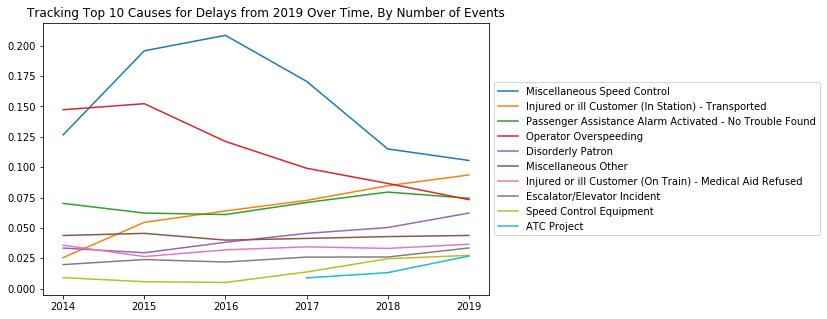

In [20]:
top_2019_delays_count = (delay_type_count[delay_type_count.year == 2019].groupby('delay_reason')['proportion'].sum()
                                                                        .sort_values(ascending = False)
                                                                        .index.values[:10])

plt.figure(figsize = (8, 5))
                    
for delay in top_2019_delays_count:
    
    plt.plot(delay_type_count[delay_type_count.delay_reason == delay].year, 
             delay_type_count[delay_type_count.delay_reason == delay].proportion,
             label = delay)
                    
plt.legend(bbox_to_anchor = (1, 0.8), loc = "upper left")
plt.title('Tracking Top 10 Causes for Delays from 2019 Over Time, By Number of Events')

plt.show()

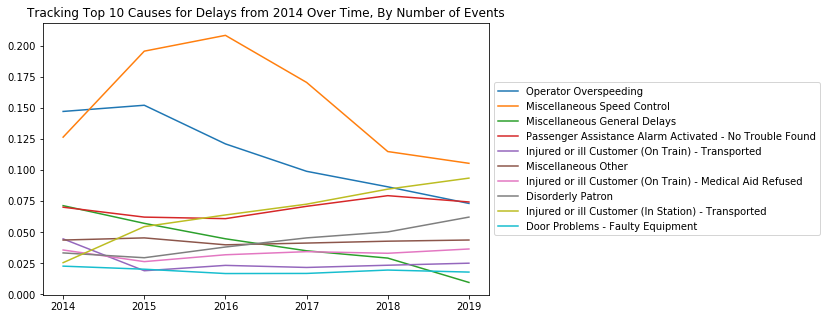

In [21]:
top_2014_delays_count = (delay_type_count[delay_type_count.year == 2014].groupby('delay_reason')['proportion'].sum()
                                                                        .sort_values(ascending = False)
                                                                        .index.values[:10])

plt.figure(figsize = (8, 5))
                    
for delay in top_2014_delays_count:
    
    plt.plot(delay_type_count[delay_type_count.delay_reason == delay].year, 
             delay_type_count[delay_type_count.delay_reason == delay].proportion,
             label = delay)
                    
plt.legend(bbox_to_anchor = (1, 0.8), loc = "upper left")
plt.title('Tracking Top 10 Causes for Delays from 2014 Over Time, By Number of Events')

plt.show()

## By Duration

To account for the fact that not all delays are of equal severity (e.g. if a passenger assistance alarm was activated but turned out to be a false alarm, it would get resolved a lot faster than an injury), I repeated the above analysis for the duration of delays.

In [22]:
delay_type_dur = (df.groupby('year')
                    .apply(lambda x: x.groupby('desc')['min_delay'].sum() / x['min_delay'].sum())
                    .reset_index(drop = False)
                    .rename(columns = {'desc': 'delay_reason', 'min_delay': 'proportion'}))

delay_type_dur.head()

year                 delay_reason  proportion
0  2014             Air Conditioning    0.001525
1  2014          Alternating Current    0.000481
2  2014  Assault / Employee Involved    0.003040
3  2014    Assault / Patron Involved    0.009695
4  2014                         Body    0.004147

Some observations:
- Injured/ill customer and disorderly patrons account for a large proportion of delays by time (can increased crowding causing this?)
- We are getting less miscellaneous speed control-related delays
- Fire/smoke and faulty equipment are not as big of a problem as they used to be
- Work on implement Automatic Train Control (ATC) began in 2017 and should have a definite completion date, after which it would no longer be a source of delays (currently installed for part of YU line)

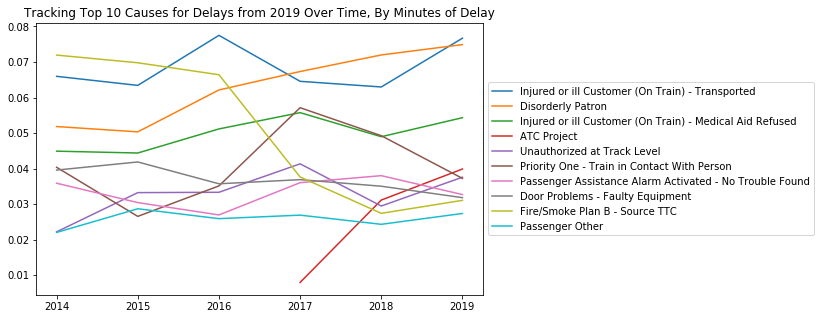

In [23]:
top_2019_delays_dur = (delay_type_dur[delay_type_dur.year == 2019].groupby('delay_reason')['proportion'].sum()
                                                                  .sort_values(ascending = False)
                                                                  .index.values[:10])

plt.figure(figsize = (8, 5))
                    
for delay in top_2019_delays_dur:
    
    plt.plot(
        delay_type_dur[delay_type_dur.delay_reason == delay].year, 
        delay_type_dur[delay_type_dur.delay_reason == delay].proportion,
        label = delay
    )
                    
plt.legend(bbox_to_anchor = (1, 0.8), loc = "upper left")
plt.title('Tracking Top 10 Causes for Delays from 2019 Over Time, By Minutes of Delay')

plt.show()

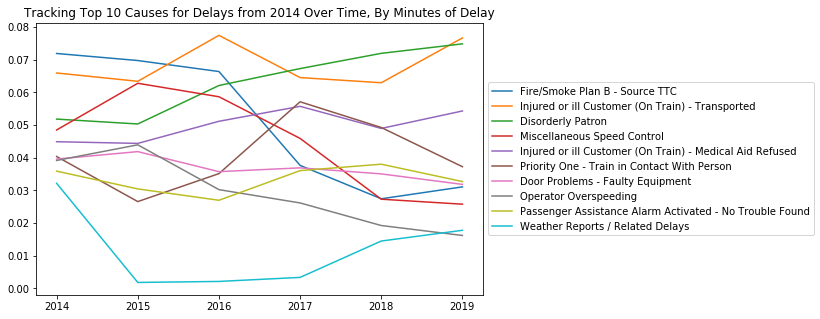

In [24]:
top_2014_delays_dur = (delay_type_dur[delay_type_dur.year == 2014].groupby('delay_reason')['proportion'].sum()
                                                                  .sort_values(ascending = False)
                                                                  .index.values[:10])

plt.figure(figsize = (8, 5))
                    
for delay in top_2014_delays_dur:
    
    plt.plot(
        delay_type_dur[delay_type_dur.delay_reason == delay].year, 
        delay_type_dur[delay_type_dur.delay_reason == delay].proportion,
        label = delay
    )
                    
plt.legend(bbox_to_anchor = (1, 0.8), loc = "upper left")
plt.title('Tracking Top 10 Causes for Delays from 2014 Over Time, By Minutes of Delay')

plt.show()

We know that fire/smoke is becoming less of a problem in relative terms, but what about in absolute terms? As shown below, delays caused by fire/smoke have also decreased significantly in absolute terms. 

In [25]:
delay_type_summ = (df.groupby(['year', 'desc'])['min_delay'].sum()
                     .rename('delay_dur')
                     .unstack('year'))

delay_type_summ[delay_type_summ.index.isin(top_2014_delays_dur)]

year                                                  2014    2015    2016  \
desc                                                                         
Disorderly Patron                                   2481.0  2128.0  2831.0   
Door Problems - Faulty Equipment                    1895.0  1770.0  1628.5   
Fire/Smoke Plan B - Source TTC                      3443.0  2949.5  3026.0   
Injured or ill Customer (On Train) - Medical Ai...  2149.5  1876.5  2331.5   
Injured or ill Customer (On Train) - Transported    3157.0  2680.5  3531.0   
Miscellaneous Speed Control                         2321.5  2655.0  2674.0   
Operator Overspeeding                               1874.5  1858.0  1377.5   
Passenger Assistance Alarm Activated - No Troub...  1718.0  1287.0  1229.0   
Priority One - Train in Contact With Person         1932.5  1123.0  1601.0   
Weather Reports / Related Delays                    1539.5    76.0    96.0   

year                                                  2017    2018    2019  
desc                                                                        
Disorderly Patron                                   2858.5  3888.0  3802.5  
Door Problems - Faulty Equipment                    1567.0  1893.5  1616.5  
Fire/Smoke Plan B - Source TTC                      1599.0  1481.5  1578.0  
Injured or ill Customer (On Train) - Medical Ai...  2367.5  2645.5  2758.5  
Injured or ill Customer (On Train) - Transported    2741.5  3401.5  3894.0  
Miscellaneous Speed Control                         1950.0  1474.5  1308.5  
Operator Overspeeding                               1110.5  1039.0   822.0  
Passenger Assistance Alarm Activated - No Troub...  1531.0  2054.0  1660.5  
Priority One - Train in Contact With Person         2426.5  2661.0  1891.5  
Weather Reports / Related Delays                     142.0   782.5   902.5

## Mean, Standard Deviation of Delays

To better understand the differences by type of delay, I computed the mean and standard deviation of delay events by cause. 

From this, we can see that the type of delays that require a long time to resolve tend to be rare and equipment or infrastructure-related (e.g. high voltage, structure-related problems), with the exception being when a train hits a person. The frequent delays often require less time to resolve, in the magnitude of a few minutes. As a commuter, this is somewhat good news, since it means I'm expected to encounter mostly quick delays during my trips.

In [26]:
def get_mean_sd(x):
    return pd.Series({'delay_mean': x.min_delay.mean(), 
                      'delay_sd': x.min_delay.std(), 
                      'delay_sum': x.min_delay.sum(),
                      'n': x.indicator_ns.sum()})

delay_type_stats = (df.groupby('desc')
                      .apply(get_mean_sd)
                      .sort_values(by = 'delay_sum', ascending = False)
                      .reset_index(drop = False))

delay_type_stats.head()

desc  delay_mean   delay_sd  \
0   Injured or ill Customer (On Train) - Transported    6.178128   6.501582   
1                                  Disorderly Patron    3.511419   3.647933   
2  Injured or ill Customer (On Train) - Medical A...    3.586951   3.365778   
3                     Fire/Smoke Plan B - Source TTC   15.104077  16.943163   
4                        Miscellaneous Speed Control    0.663070   0.812809   

   delay_sum        n  
0    19405.5   3138.0  
1    17989.0   5121.0  
2    14129.0   3937.0  
3    14077.0    930.0  
4    12383.5  18486.0

In [27]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    mode = 'markers',
    x = delay_type_stats['delay_mean'],
    y = delay_type_stats['n'],
    hovertext = delay_type_stats['desc'],
    hoverinfo = "text",
    showlegend = False
))

fig.update_layout(
    title = 'Average Delay Event Duration Versus Number of Delays, By Cause'
)

fig.show()

## By Subway Line

Next, I investigated the differences in the type of delays by subway line. For example, unlike the other three lines (except for a few stations), the Scarborough RT line is above ground, so could it face different operational issues because it is less protected by tunnels?

*Note*: I limited the analysis to delays on and after 2018 due to the addition of six stations to the YU line in Dec 2017.

In [28]:
delay_type_line = df[(df.year > 2017) & 
                     (df.line_cleaned.isin([
                         'YU', 'BD', 'SRT', 'SHP'
                     ]))].groupby(['line_cleaned', 'desc']).apply(get_mean_sd)

delay_type_line.head()

delay_mean   delay_sd  delay_sum  \
line_cleaned desc                                                            
BD           Air Conditioning               3.513514   1.070348      130.0   
             Alternating Current            4.375000   1.060660       35.0   
             Assault / Employee Involved    1.673729   3.429942      197.5   
             Assault / Patron Involved      5.571429  36.240992     1131.0   
             Body                           3.680000   1.618391      276.0   

                                              n  
line_cleaned desc                                
BD           Air Conditioning              37.0  
             Alternating Current            8.0  
             Assault / Employee Involved   88.0  
             Assault / Patron Involved    203.0  
             Body                          75.0

As shown below, there are some overlap in top delays by line, but also some interesting differences:

- Ill/injured customers, passenger assistance alarms and disorderly patrons are among the top causes regardless of line, so are overspeeding and speed control-related delays
- YU has experienced extensive delays related to ATC upgrades in 2018 and 2019, which is unfortunately expected to continue into the current year (2020)
- SHP sees the fewest delays (could it have lower ridership or less train service?)
- As expected, SRT has a lot more delays related to weather in addition to equipment

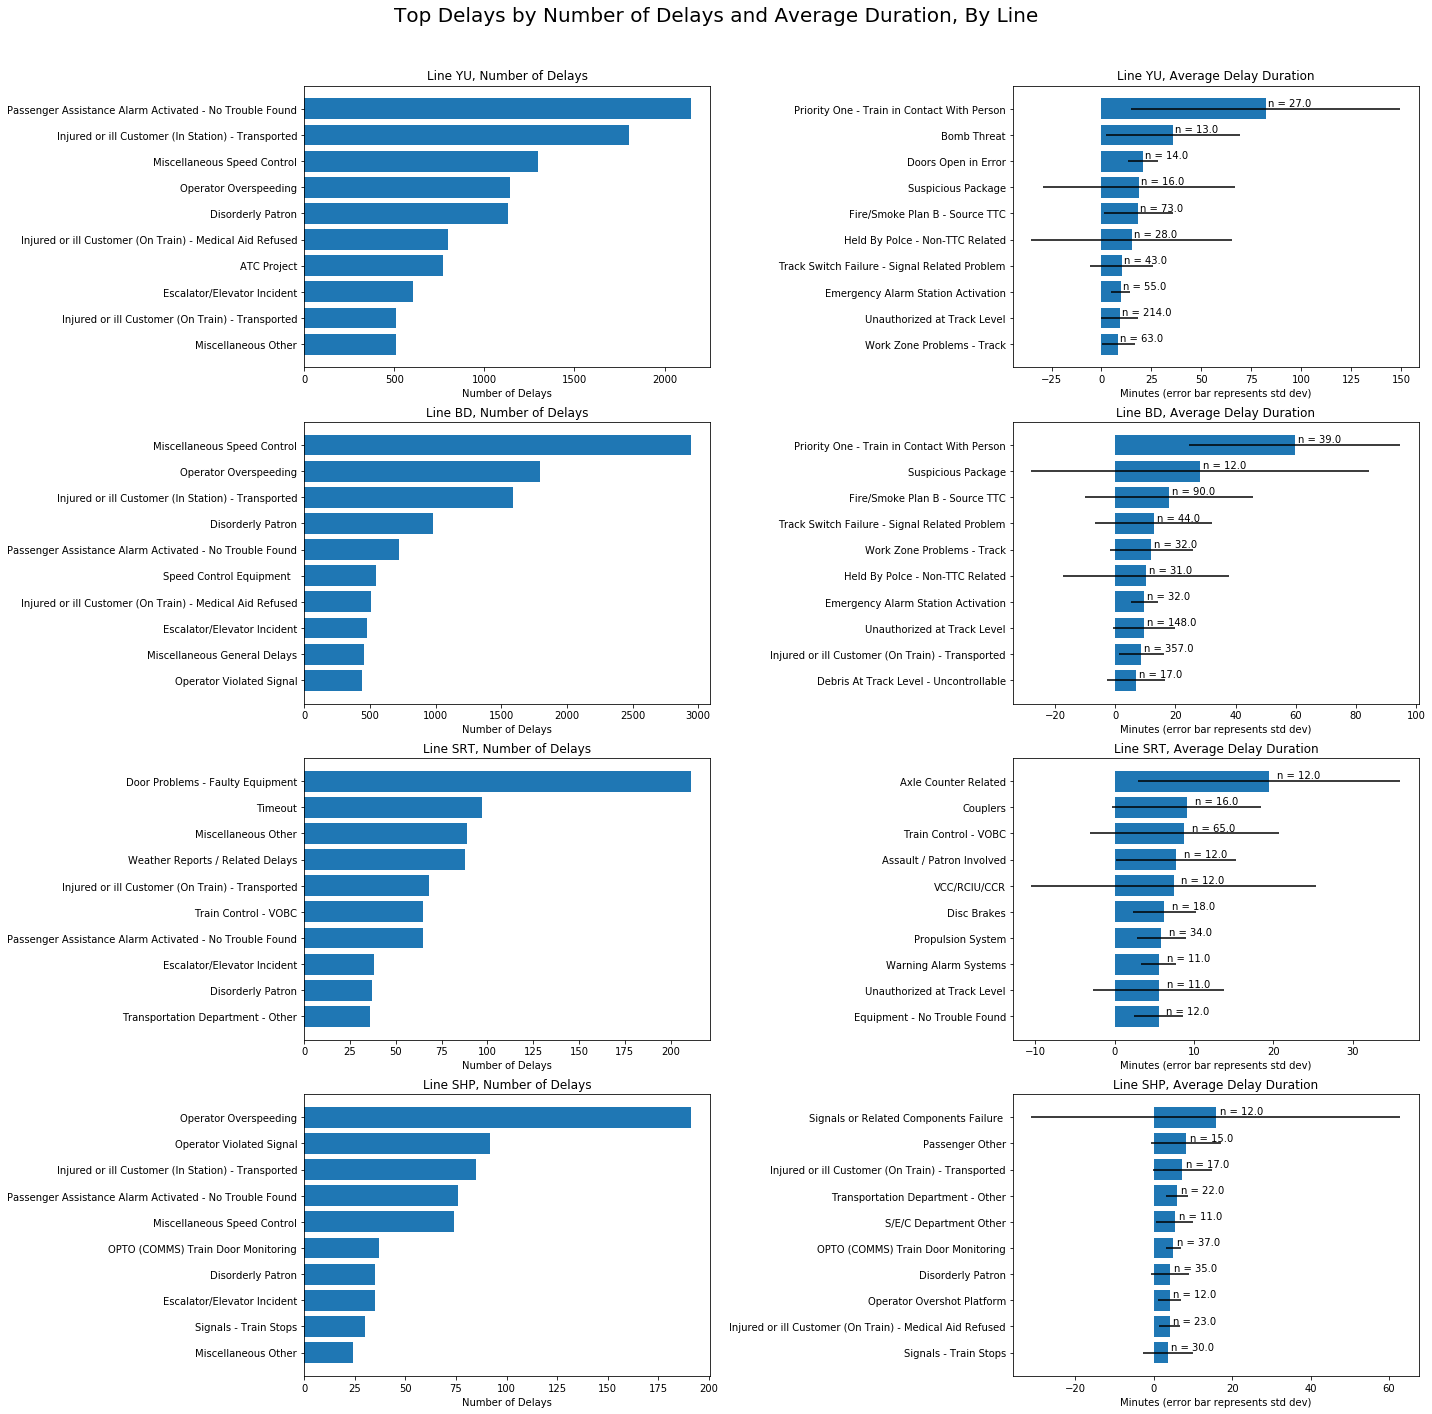

In [29]:
n = 10 # Exclude extremely rare types when plotting top causes by average delay duration

fig, axes = plt.subplots(ncols = 2, nrows = 4, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.8, hspace = 0.3)

for ii, line_i in enumerate(['YU', 'BD', 'SRT', 'SHP']):
    
    y_pos = np.arange(n)
    
    data_n = delay_type_line.loc[line_i].sort_values(by = 'n', ascending = False)[:n]    
    x_posn = data_n.n
    
    axes[ii][0].barh(y_pos, x_posn, align ='center')
    axes[ii][0].set_yticks(y_pos)
    axes[ii][0].set_yticklabels(data_n.index)
    axes[ii][0].invert_yaxis() 
    axes[ii][0].set_xlabel('Number of Delays')
    axes[ii][0].set_title(f'Line {line_i}, Number of Delays')
    
    data_m = delay_type_line[delay_type_line.n > 10].loc[line_i].sort_values(by = 'delay_mean', ascending = False)[:n]
    x_posm = data_m.delay_mean
    x_err = data_m.delay_sd
    
    axes[ii][1].barh(y_pos, x_posm, xerr = x_err, align ='center')
    
    for x, y, s in zip(x_posm, y_pos, data_m['n']):
        axes[ii][1].annotate(f'n = {s}', xy = (x, y), xytext = (x + 1, y - 0.1))
    
    axes[ii][1].set_yticks(y_pos)
    axes[ii][1].set_yticklabels(data_m.index)
    axes[ii][1].invert_yaxis()
    axes[ii][1].set_xlabel('Minutes (error bar represents std dev)')
    axes[ii][1].set_title(f'Line {line_i}, Average Delay Duration')

fig.suptitle('Top Delays by Number of Delays and Average Duration, By Line', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top = 0.925)

plt.show()

# Station Differences

The daily delay statistics (average number of delays per day and average length of delay per day) by station in map format has been plotted below to better visualize the delay patterns by route.

*Note*: map is for illustrative purposes and not drawn to scale.

In [30]:
new_stations = ['VAUGHAN MC STATION', 'HIGHWAY 407 STATION', 'PIONEER VILLAGE STATION', 
                'YORK UNIVERSITY STATION', 'FINCH WEST STATION', 'DOWNSVIEW PARK STATION']

def get_n_dur_station(data):
    return pd.Series({'n_delays': data.indicator_station.sum(), 
                      'min_delays': data.min_delay.sum()})

def get_mean_sd_station(data):
    return pd.Series({'n_delays': data.n_delays.sum(),
                      'n_delays_daily_mean': data.n_delays.mean(skipna = True),
                      'n_delays_daily_sd': data.n_delays.std(skipna = True),
                      'min_delays': data.min_delays.sum(),
                      'min_delays_daily_mean': data.min_delays.mean(skipna = True),
                      'min_delays_daily_sd': data.min_delays.std(skipna = True)})   

temp = (df.groupby(['station_cleaned', 'date'])
          .apply(get_n_dur_station)
          .fillna(0)
          .reset_index(drop = False))

temp.loc[(temp.station_cleaned.isin(new_stations)) & (temp.date < '2017-12-17'), 'n_delays'] = np.nan
temp.loc[(temp.station_cleaned.isin(new_stations)) & (temp.date < '2017-12-17'), 'min_delays'] = np.nan

station_summ = (temp.groupby('station_cleaned')
                    .apply(get_mean_sd_station)
                    .sort_values(by = 'min_delays', ascending = False)
                    .reset_index(drop = False))

station_summ.head()

station_cleaned  n_delays  n_delays_daily_mean  n_delays_daily_sd  \
0     KENNEDY BD STATION    9121.0             4.162939           2.129037   
1  SHEPPARD WEST STATION    8662.0             3.953446           1.889076   
2        KIPLING STATION    9136.0             4.169785           2.219346   
3       EGLINTON STATION    8185.0             3.735737           1.792933   
4          FINCH STATION    9444.0             4.310361           1.841549   

     min_delays  min_delays_daily_mean  min_delays_daily_sd  
0  10804.288044               4.931213            15.204580  
1   9697.363454               4.425999             9.889031  
2   8649.038044               3.947530             5.602017  
3   8280.821787               3.779471             8.612393  
4   8018.980121               3.659964             9.802743

In [31]:
# Contains coordinates of stations for mapping purposes
station_coords = pd.read_csv('helper_data/station_coords.csv')
station_coords.head()

station line  xcoord  ycoord
0       VAUGHAN MC STATION   YU       8      22
1      HIGHWAY 407 STATION   YU       8      21
2  PIONEER VILLAGE STATION   YU       9      20
3  YORK UNIVERSITY STATION   YU      10      19
4       FINCH WEST STATION   YU      11      18

In [32]:
station_stats = station_coords.merge(
    station_summ, 
    left_on = 'station', 
    right_on = 'station_cleaned', 
    how = 'left'
)

custom_text = lambda x, y, z, k, l, m, n: (
    f"{x}"
    f"<br># delays: {round(y)}"
    f"<br>Avg daily # delays: {round(z)}"
    f"<br>Stdev daily # delays: {round(k)}"
    f"<br>Total duration: {round(l, 2)}"
    f"<br>Avg daily duration: {round(m, 2)}"
    f"<br>Stdev daily duration: {round(n, 2)}"
)

station_stats['text'] = list(map(
    custom_text,    
    station_stats.station, 
    station_stats.n_delays, 
    station_stats.n_delays_daily_mean, 
    station_stats.n_delays_daily_sd, 
    station_stats.min_delays, 
    station_stats.min_delays_daily_mean, 
    station_stats.min_delays_daily_sd
))

station_stats.head()

station line  xcoord  ycoord          station_cleaned  \
0       VAUGHAN MC STATION   YU       8      22       VAUGHAN MC STATION   
1      HIGHWAY 407 STATION   YU       8      21      HIGHWAY 407 STATION   
2  PIONEER VILLAGE STATION   YU       9      20  PIONEER VILLAGE STATION   
3  YORK UNIVERSITY STATION   YU      10      19  YORK UNIVERSITY STATION   
4       FINCH WEST STATION   YU      11      18       FINCH WEST STATION   

   n_delays  n_delays_daily_mean  n_delays_daily_sd   min_delays  \
0    2100.0             2.818792           1.431471  2943.288298   
1    1397.0             1.875168           0.932818   407.288298   
2    1416.0             1.900671           0.963479   497.288298   
3    1384.0             1.857718           0.916484   267.288298   
4    1502.0             2.016107           0.997178   493.788298   

   min_delays_daily_mean  min_delays_daily_sd  \
0               3.950723             7.742997   
1               0.546696             3.608544   
2               0.667501             6.192736   
3               0.358776             1.748852   
4               0.662803             2.513626   

                                                text  
0  VAUGHAN MC STATION<br># delays: 2100<br>Avg da...  
1  HIGHWAY 407 STATION<br># delays: 1397<br>Avg d...  
2  PIONEER VILLAGE STATION<br># delays: 1416<br>A...  
3  YORK UNIVERSITY STATION<br># delays: 1384<br>A...  
4  FINCH WEST STATION<br># delays: 1502<br>Avg da...

In [33]:
fig = go.Figure()

# Plot route outlines
fig.add_trace(go.Scatter(
    x = station_stats[station_stats.line.isin(['BD', 'SRT'])]['xcoord'],
    y = station_stats[station_stats.line.isin(['BD', 'SRT'])]['ycoord'],
    mode = 'lines',
    line = dict(color = 'lightslategrey'),
    showlegend = False
))

fig.add_trace(go.Scatter(
    x = station_stats[station_stats.line.isin(['YU'])]['xcoord'],
    y = station_stats[station_stats.line.isin(['YU'])]['ycoord'],
    mode = 'lines',
    line = dict(color = 'lightslategrey'),
    showlegend = False
))

fig.add_trace(go.Scatter(
    x = station_stats[station_stats.line.isin(['SHP'])]['xcoord'],
    y = station_stats[station_stats.line.isin(['SHP'])]['ycoord'],
    mode = 'lines',
    line = dict(color = 'lightslategrey'),
    showlegend = False
))

# Connects SHP and YU lines by intersecting station
fig.add_trace(go.Scatter(
    x = station_stats[station_stats.station.isin(['SHEPPARD STATION', 'YONGE SHP STATION'])]['xcoord'],
    y = station_stats[station_stats.station.isin(['SHEPPARD STATION', 'YONGE SHP STATION'])]['ycoord'],
    mode = 'lines',
    line = dict(color = 'lightslategrey'),
    showlegend = False
))

# Plot points
for name, group in station_stats.groupby('line'):   
    fig.add_trace(go.Scatter(
        x = group['xcoord'],
        y = group['ycoord'],
        mode = 'markers',
        marker = dict(
            size = group['min_delays_daily_mean'] * 3, 
            color = cmap[name],
            line = dict(width = 1, color = 'darkslategrey')
        ),
        text = group['text'],
        hoverinfo = 'text',
        name = name
    ))
    
fig.update_layout(
    legend = go.layout.Legend(itemsizing = 'constant'),
    plot_bgcolor = 'white',
    title = 'Average Daily Delay Duration By Station (minutes)',
    xaxis = dict(visible = False),
    yaxis = dict(visible = False)
)

fig.show()

In [34]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = station_stats[station_stats.line.isin(['BD', 'SRT'])]['xcoord'],
    y = station_stats[station_stats.line.isin(['BD', 'SRT'])]['ycoord'],
    mode = 'lines',
    line = dict(color = 'lightslategrey'),
    showlegend = False
))

fig.add_trace(go.Scatter(
    x = station_stats[station_stats.line.isin(['YU'])]['xcoord'],
    y = station_stats[station_stats.line.isin(['YU'])]['ycoord'],
    mode = 'lines',
    line = dict(color = 'lightslategrey'),
    showlegend = False
))

fig.add_trace(go.Scatter(
    x = station_stats[station_stats.line.isin(['SHP'])]['xcoord'],
    y = station_stats[station_stats.line.isin(['SHP'])]['ycoord'],
    mode = 'lines',
    line = dict(color = 'lightslategrey'),
    showlegend = False
))

fig.add_trace(go.Scatter(
    x = station_stats[station_stats.station.isin(['SHEPPARD STATION', 'YONGE SHP STATION'])]['xcoord'],
    y = station_stats[station_stats.station.isin(['SHEPPARD STATION', 'YONGE SHP STATION'])]['ycoord'],
    mode = 'lines',
    line = dict(color = 'lightslategrey'),
    showlegend = False
))

for name, group in station_stats.groupby('line'):
    fig.add_trace(go.Scatter(
        x = group['xcoord'],
        y = group['ycoord'],
        mode = 'markers',
        marker = dict(
            size = group['n_delays_daily_mean'] * 3, 
            color = cmap[name],
            line = dict(width = 1, color = 'darkslategrey')
        ),
        text = group['text'],
        hoverinfo = 'text',
        name = name
    ))
    
fig.update_layout(
    legend = go.layout.Legend(itemsizing = 'constant'),
    plot_bgcolor = 'white',
    title = 'Average Daily Number of Delays By Station',
    xaxis = dict(visible = False),
    yaxis = dict(visible = False)
)

fig.show()

The above plots show notable differences by line and by station. Not surprisingly, the YU line (very popular line) experiences a large number of delays, but a lot of them tend to be quick to resolve, such as customer-related incidents. Stations with connections between lines and terminal stations also tend to have more delays. 

Additionally, although there are greater differences by number of delay events, with a few stations jumping out as having more frequent delays, the inter-station differences become less distant when examined by duration of delays.

Next, I investigated why Kipling, Finch, Vaughan MC, Sheppard West, Wilson, Bloor-Yonge and Kennedy stations have more delays. Are they affected by different types of delays than the rest?

In [35]:
delay_type_station = (df[df.year > 2017].groupby(['station_cleaned', 'desc'])['min_delay'].sum()
                                        .rename('min_delay')
                                        .reset_index(drop = False)
                                        .sort_values(by = ['station_cleaned', 'min_delay'], ascending = False))

delay_type_station.head()

station_cleaned                                              desc  \
4612  YORKDALE STATION       Priority One - Train in Contact With Person   
4599  YORKDALE STATION  Injured or ill Customer (On Train) - Transported   
4588  YORKDALE STATION                                 Disorderly Patron   
4611  YORKDALE STATION                                   Passenger Other   
4576  YORKDALE STATION                                       ATC Project   

      min_delay  
4612     181.00  
4599      75.00  
4588      72.50  
4611      58.50  
4576      58.35

In [36]:
delay_type_station_pivot = pd.pivot_table(
    delay_type_station,
    index = ['station_cleaned'],
    columns = ['desc'],
    values = ['min_delay'],
    aggfunc = 'sum'
).fillna(0)

delay_type_station_pivot.index = pd.Categorical(
    delay_type_station_pivot.index,
    categories = line_station_lookup['YU'] + line_station_lookup['BD'] + \
                 line_station_lookup['SRT'] + line_station_lookup['SHP'],
    ordered = True
)

delay_type_station_pivot.sort_index(ascending = False, inplace = True)

delay_type_station_pivot.head()

min_delay                                 \
desc              ATC Operator Related ATC Project ATC RC&S Equipment   
DON MILLS STATION                  0.0        0.35                0.0   
LESLIE STATION                     0.0        0.35                0.0   
BESSARION STATION                  0.0        0.35                0.0   
BAYVIEW STATION                    0.0        0.35                0.0   
YONGE SHP STATION                  0.0        0.35                0.0   

                                                                          \
desc              ATC Signals Other Air Conditioning Alternating Current   
DON MILLS STATION               0.0              0.0                 0.0   
LESLIE STATION                  0.0              0.0                 0.0   
BESSARION STATION               0.0              0.0                 0.0   
BAYVIEW STATION                 0.0              0.0                 0.0   
YONGE SHP STATION               0.0              0.0                 0.0   

                                                                         \
desc              Assault / Employee Involved Assault / Patron Involved   
DON MILLS STATION                         0.5                       3.0   
LESLIE STATION                            0.0                      14.0   
BESSARION STATION                         0.0                       0.0   
BAYVIEW STATION                           0.0                       6.0   
YONGE SHP STATION                         0.5                       2.5   

                                             ...                       \
desc              Axle Counter Related Body  ... VCC/RCIU/CCR Vehicle   
DON MILLS STATION                  0.0  0.0  ...          0.0     0.0   
LESLIE STATION                     0.0  0.0  ...          0.0     0.0   
BESSARION STATION                  0.0  0.0  ...          0.0     0.0   
BAYVIEW STATION                    0.0  0.0  ...          0.0     0.0   
YONGE SHP STATION                  0.0  5.0  ...          0.0     0.0   

                                                                          \
desc              Warning Alarm Systems Weather Reports / Related Delays   
DON MILLS STATION                   0.0                         0.006757   
LESLIE STATION                      5.0                         0.006757   
BESSARION STATION                   0.0                         0.006757   
BAYVIEW STATION                     0.0                         0.006757   
YONGE SHP STATION                   0.0                         0.006757   

                                                         \
desc              Wind Shield Work Refusal Work Vehicle   
DON MILLS STATION         0.0          0.0          0.0   
LESLIE STATION            0.0          0.0          0.0   
BESSARION STATION         0.0          0.0          0.0   
BAYVIEW STATION           0.0          0.0          0.0   
YONGE SHP STATION         0.0          5.0          6.0   

                                                                           \
desc              Work Zone Problems - Signals Work Zone Problems - Track   
DON MILLS STATION                          5.0                        0.0   
LESLIE STATION                             0.0                        0.0   
BESSARION STATION                          0.0                        0.0   
BAYVIEW STATION                            0.0                        8.0   
YONGE SHP STATION                          0.0                        0.0   

                                                  
desc              Yard/Carhouse Related Problems  
DON MILLS STATION                            0.0  
LESLIE STATION                               0.0  
BESSARION STATION                            0.0  
BAYVIEW STATION                              0.0  
YONGE SHP STATION                            0.0  

[5 rows x 136 columns]

According to the heatmap of delays by cause and station below: 

- For Vaughan MC, Sheppard West and Wilson, the top causes for delays are ATC project, operator staffing issues and rail problems
- For Kipling and Finch, the top causes are speed control and miscellaneous delays (from personal experience, the train often slows down as it approaches Finch due to heavier traffic)
- For Bloor-Yonge: the top causes are disorderly patrons, ill customers and equipment issues (door, switch)
- For Kennedy, the top causes are fire/smoke, weather-related issues and door problems (pointing to aging infrastructure issues), as well as assault involving a patron

In [37]:
fig = go.Figure(
    data = go.Heatmap(
        x = [x[1] for x in delay_type_station_pivot.columns],
        y = delay_type_station_pivot.index,
        z = delay_type_station_pivot.values,
        ygap = 1
    )
)

fig.update_layout(
    autosize = False,
    width = 1000,
    height = 1500,
    font = dict(size = 10),
    xaxis = dict(showticklabels = False),
    title = 'Total Delay Duration by Station and Cause (minutes), 2018 Onwards'
)

fig.show()

# Seasonality

Lastly, I investigated seasonality of delay patterns. My hypothesis is more delays during rush hours on weekdays, and less delay in summer months as more people go away for vacation. 

In [38]:
seasonal_summ = (df.groupby(['date', 'year', 'month', 'weekday', 'hour'])
                   .apply(get_mean_sd)
                   .reset_index(drop = False))

seasonal_summ.head()

date  year  month weekday  hour  delay_mean  delay_sd  delay_sum   n
0 2014-01-01  2014      1  Sunday     0         NaN       NaN        NaN NaN
1 2014-01-01  2014      1  Sunday     1         NaN       NaN        NaN NaN
2 2014-01-01  2014      1  Sunday     2         NaN       NaN        NaN NaN
3 2014-01-01  2014      1  Sunday     3         NaN       NaN        NaN NaN
4 2014-01-01  2014      1  Sunday     4         NaN       NaN        NaN NaN

To normalize for year, each series was rescaled by the first value (i.e. at hour 0). As expected, on an hourly basis, delays are more common during the morning and evening rush hours. This has been consistent across years. 

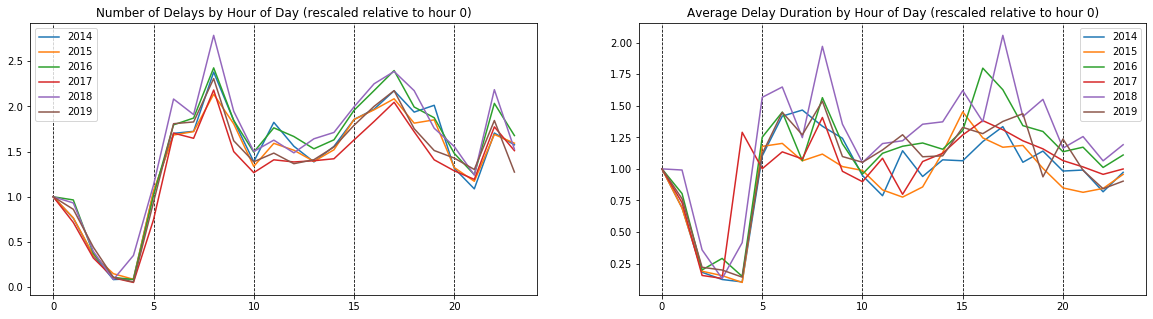

In [39]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (20, 5))

for name, group in seasonal_summ.groupby('year'):
    
    ax1.plot(group.groupby('hour')['n'].sum() / group.groupby('hour')['n'].sum()[0], label = name)
    
    temp_i = group.groupby('hour')['delay_sum'].agg(['mean']).reset_index(drop = False)
    ax2.plot(temp_i['hour'], temp_i['mean'] / temp_i['mean'][0], label = name)
    
ax1.grid(b = True, which = 'major', axis = 'x', color = 'black', linestyle = '--')
ax1.set_title('Number of Delays by Hour of Day (rescaled relative to hour 0)')
ax1.legend()

ax2.grid(b = True, which = 'major', axis = 'x', color = 'black', linestyle = '--')
ax2.set_title('Average Delay Duration by Hour of Day (rescaled relative to hour 0)')
ax2.legend()

plt.show()

On a weekly basis, delays are worse Monday through Friday, and drop off significantly on the weekends. During the week, the delay duration seems to relatively lower on Mondays and Fridays (2018 being an exception year), with Tuesday/Wednesday being the peak. Similar to above, each series was rescaled by the first value (i.e. at beginning of the week, or Sunday). 

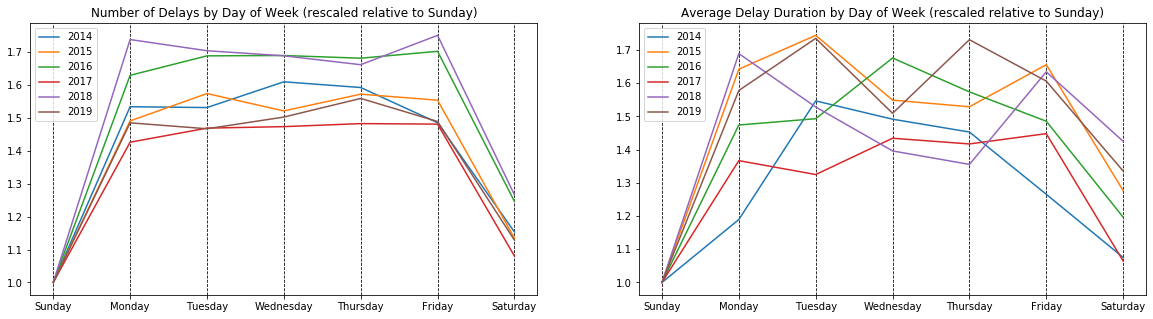

In [40]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (20, 5))

for name, group in seasonal_summ.groupby('year'):
    
    ax1.plot(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], 
             group.groupby('weekday')['n'].sum() / group.groupby('weekday')['n'].sum()[0], 
             label = name)
    
    temp_i = (group.groupby(['date', 'weekday'])['delay_sum'].sum()
                   .groupby('weekday')
                   .agg(['mean'])
                   .reset_index(drop = False))
    ax2.plot(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
             temp_i['mean'] / temp_i['mean'][0], label = name)
    
ax1.grid(b = True, which = 'major', axis = 'x', color = 'black', linestyle = '--')
ax1.set_title('Number of Delays by Day of Week (rescaled relative to Sunday)')
ax1.legend()

ax2.grid(b = True, which = 'major', axis = 'x', color = 'black', linestyle = '--')
ax2.set_title('Average Delay Duration by Day of Week (rescaled relative to Sunday)')
ax2.legend()

plt.show()

On a monthly basis, the summer months do not correspond to periods of low delays. In fact, I detected no obvious consistent seasonality patterns by month. 

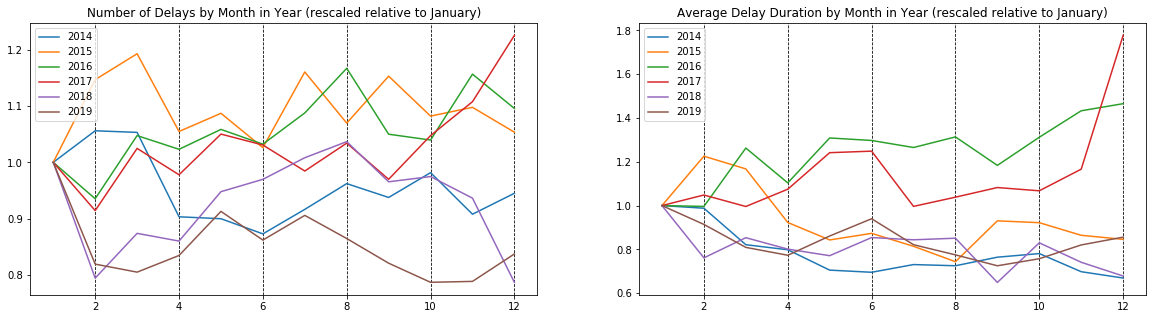

In [41]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (20, 5))

for name, group in seasonal_summ.groupby('year'):
        
    ax1.plot(group.groupby('month')['n'].sum() / group.groupby('month')['n'].sum()[1], label = name)

    temp_i = (group.groupby(['date', 'month'])['delay_sum'].sum()
                   .groupby('month')
                   .agg(['mean'])
                   .reset_index(drop = False))
    ax2.plot(temp_i['month'], temp_i['mean'] / temp_i['mean'][0], label = name)
    
ax1.grid(b = True, which = 'major', axis = 'x', color = 'black', linestyle = '--')
ax1.set_title('Number of Delays by Month in Year (rescaled relative to January)')
ax1.legend()

ax2.grid(b = True, which = 'major', axis = 'x', color = 'black', linestyle = '--')
ax2.set_title('Average Delay Duration by Month in Year (rescaled relative to January)')
ax2.legend()

plt.show()

Annually, there was an uptick in delays in 2018, presumably due to the addition of six new stations to the YU line. It is encouraging to see improvements in 2019 compared to the year before, but it is still worse than the earlier years.

In [42]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (20, 5))

ax1.plot(seasonal_summ.groupby('year')['n'].sum())

temp = (seasonal_summ.groupby(['date', 'year'])['delay_sum'].sum()
                     .groupby('year')
                     .agg(['mean'])=
                     .reset_index(drop = False))
ax2.plot(temp['year'], temp['mean'])

ax1.grid(b = True, which = 'major', axis = 'x', color = 'black', linestyle = '--')
ax1.set_title('Number of Delays by Year')

ax2.grid(b = True, which = 'major', axis = 'x', color = 'black', linestyle = '--')
ax2.set_title('Average Delay Duration by Year')

plt.show()

SyntaxError: invalid syntax (<ipython-input-42-ca9d40ccd225>, line 7)

# Delays from Finch-Union on YU Line

To answer one of my original questions about delays by weekday (and potentially season) for the Yonge portion ofthe YU line, I repeated the above analysis for just the stations on my usual route, color-coded for season, and found that, overall, for the spring and summer months (coming up), Tuesday and Wednesday appear to be the best day to use the subway. For fall, Monday appears to be the best day, while for winter, Tuesday appears to be the best day for delays.

In [ ]:
yonge_stations = line_station_lookup['YU'][-17:]

yonge_summ = (df[(df.station_cleaned.isin(yonge_stations)) & 
                 (df.year > 2016)].groupby(['date', 'month', 'weekday'])
                                  .apply(get_mean_sd)
                                  .reset_index(drop = False))

In [ ]:
cmap = {
    12: 'blue', 1: 'blue', 2: 'blue',
    3: 'green', 4: 'green', 5: 'green',
    6: 'red', 7: 'red', 8: 'red',
    9: 'orange', 10: 'orange', 11: 'orange'
}

fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (20, 5))

for name, group in yonge_summ.groupby('month'):
    
    ax1.plot(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], 
             group.groupby('weekday')['n'].sum() / group.groupby('weekday')['n'].sum()[0], 
             label = name, c = cmap[name])
    
    temp_i = (group.groupby(['date', 'weekday'])['delay_sum'].sum()
                   .groupby('weekday')
                   .agg(['mean'])
                   .reset_index(drop = False))
    ax2.plot(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
             temp_i['mean'] / temp_i['mean'][0], 
             label = name, c = cmap[name])
    
ax1.grid(b = True, which = 'major', axis = 'x', color = 'black', linestyle = '--')
ax1.set_title('Number of Delays by Day of Week by Month')
ax1.legend()

ax2.grid(b = True, which = 'major', axis = 'x', color = 'black', linestyle = '--')
ax2.set_title('Average Delay Duration by Day of Week by Month')
ax2.legend()

plt.show()

# Next Steps

**Things I would like to investigate next:**

- Group delay causes into more general categories, which could simplify visualizations/comparisons
- Try fitting a regression model to predict delays at different times and stations, since we have detected some seasonality patterns and differences between stations/lines
- Analysis of the impact of outliers on overall trends, such as how would things look like if the extremely lengthy delay events were removed
- Anaylsis of delays for buses, since I also need to take the bus daily, and from personal experience, service tends to be less reliable and more affected by weather and traffic conditions (although unlikely to encouter delays lasting hours that the subway ocassionally experiences). A quick search on City of Toronto's Open Data Portal showed datasets available on buses and streetcars for 2014 - 2019 (yay!)
- Analysis of ridership counts and whether it is correlated with the rise in delays in 2018. The city's Open Data Portal publishes weekly and monthly overall TTC ridership data (not broken down by route), so the analysis may not be very detailed

**Wish list:**

- Complete lookup table of delay causes by code, since some codes did not have any explanations and I was not able to infer what they were from just the codes themselves
- Direction of trains when delays happen, since delays for trains going in one direction may not affect trains going in the opposite direction that much
- Data on scheduled closures (for maintenance, ATC project, etc.), which often happen on the weekends and weekday nights. These have been happening fairly regularly on parts of the YU line in the last several months, and do not count towards delays, but nonetheless affect the commuter experience
    - When there is no service at all, there would also be no chance for delays to occur, which could introduce a downward bias on the amount of delays
    - A related note is that it would be interesting, given sufficient historical data, to do a before-and-after analysis of whether such closures improve future delay trends (for example, does the ATC project reduce delays related to overspeeding)
- Data on speed of trains and wait time between train arrivals, since I am concerned with the total commute time, which is impacted by not just delays, but also how fast the trains are moving under normal conditions and the frequency of arrivals (sometimes trains slow down as they approach Finch station northbound on the YU line, which do not count as delays but add to the commute time)
- Data on whether shuttle buses were called in response to the delays, which would be another indicator of the severity